In [2]:
from model import *
from data import *

Using TensorFlow backend.
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/srv/conda/envs/notebook/lib/python3.7/site-packag

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

### Train with data generator

In [11]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'/data/spacenet/road/AllTrain','PAN-8BIT','PAN-GT',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=10,callbacks=[model_checkpoint])

Found 2780 images belonging to 1 classes.
Found 2780 images belonging to 1 classes.
Epoch 1/10
2000/2000 [==============================] - 150s 75ms/step - loss: 0.1566 - accuracy: 0.9568

Epoch 00001: loss improved from inf to 0.15656, saving model to unet_membrane.hdf5
Epoch 2/10
2000/2000 [==============================] - 150s 75ms/step - loss: 0.1276 - accuracy: 0.9570

Epoch 00002: loss improved from 0.15656 to 0.12759, saving model to unet_membrane.hdf5
Epoch 3/10
2000/2000 [==============================] - 150s 75ms/step - loss: 0.1183 - accuracy: 0.9602

Epoch 00003: loss improved from 0.12759 to 0.11829, saving model to unet_membrane.hdf5
Epoch 4/10
2000/2000 [==============================] - 150s 75ms/step - loss: 0.1144 - accuracy: 0.9612

Epoch 00004: loss improved from 0.11829 to 0.11444, saving model to unet_membrane.hdf5
Epoch 5/10
2000/2000 [==============================] - 204s 102ms/step - loss: 0.1088 - accuracy: 0.9620

Epoch 00005: loss improved from 0.11444 t

### Train with npy file

In [ ]:
#imgs_train,imgs_mask_train = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
#model.fit(imgs_train, imgs_mask_train, batch_size=2, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])

### test your model and save predicted results

In [5]:
from PIL import Image
import numpy as np
from skimage import transform

In [6]:
testGene = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)


30/30 [==============================] - 2s 79ms/step


/home/dspuser/UNET/data.py:124: UserWarning: data/membrane/test/0_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/dspuser/UNET/data.py:124: UserWarning: data/membrane/test/1_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/dspuser/UNET/data.py:124: UserWarning: data/membrane/test/2_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/dspuser/UNET/data.py:124: UserWarning: data/membrane/test/3_predict.png is a low contrast image
  io.imsave(os.path.join(save_path,"%d_predict.png"%i),

In [7]:
model = unet()
model.load_weights("unet_membrane.hdf5")

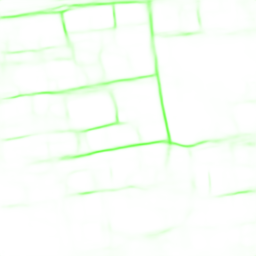

In [8]:
path = '/data/spacenet/road/AOI_5_Khartoum_Roads_Test_Public/PAN-PNG/'
pic = 'PAN_AOI_5_Khartoum_img215.png'
name = 'TestKhartoum215.png'

np_image = Image.open(path+pic)
np_image = np.array(np_image).astype('float32')/255
np_image = transform.resize(np_image,(256,256,1))
np_image = np.expand_dims(np_image, axis=0)

maskArr = model.predict(np_image)
maskArr = maskArr.reshape(256,256)

maskArrThresh = np.zeros((maskArr.shape[0], maskArr.shape[1], 4))
for row in range(0, maskArr.shape[0]):
    for col in range(0, maskArr.shape[1]):
        #if maskarr[row, col] < 0.: 
        maskArrThresh[row, col, 0] = 50 
        maskArrThresh[row, col, 1] = 255 
        maskArrThresh[row, col, 2] = 0 
        maskArrThresh[row, col, 3] = int(maskArr[row, col] * 255)
        #else: #maskArrThresh[row, col, 0:3] = 255 # maskArrThresh[row, col, 3] = 0

maskArrThresh = maskArrThresh.astype("uint8")
maskImg = Image.fromarray(maskArrThresh, 'RGBA')
maskImg

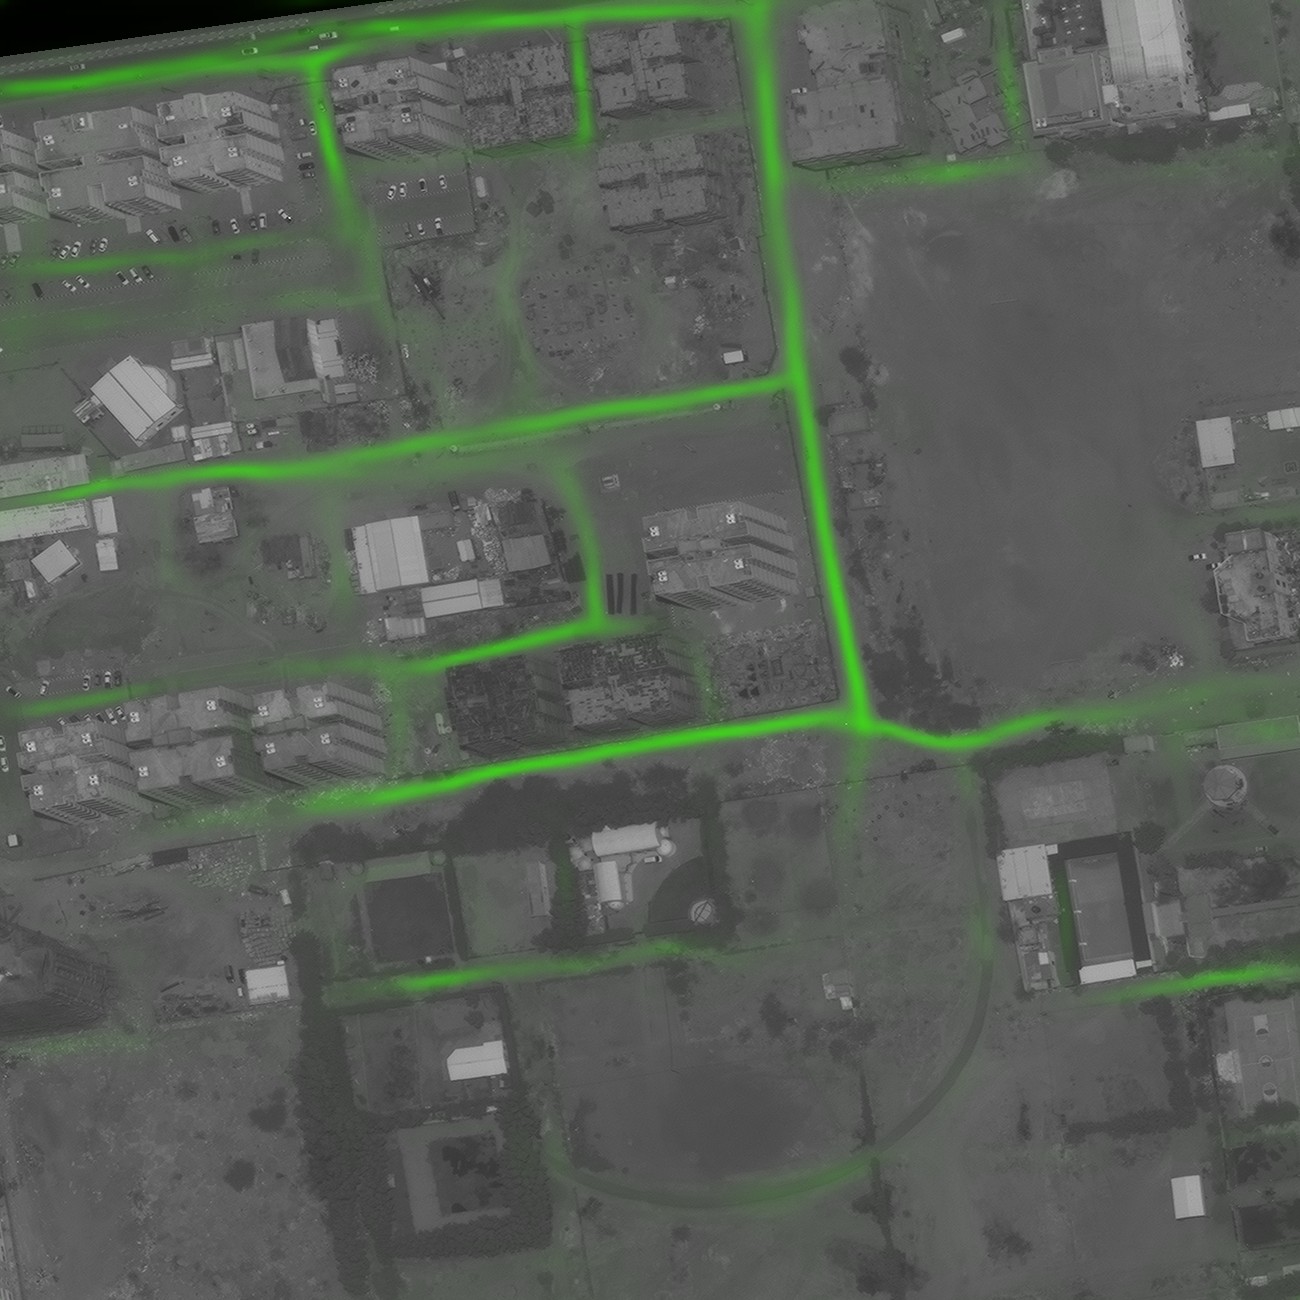

In [9]:
PANImg = Image.open(path+pic)
PANImgT = PANImg.convert('RGBA')

PANDim = (PANImgT.width, PANImgT.height) 
maskImgResize = maskImg.resize(PANDim)

comp = Image.alpha_composite(PANImgT,maskImgResize)
comp

In [11]:
comp.save(name)